Import the necessaries.

In [59]:
%matplotlib inline
import geopandas as gpd, pandas as pd

The merges we did...

In [60]:
crime_df = pd.read_csv("first_degree_murders.csv", usecols = [13, 14])
crime_df.dropna(inplace = True)
crime_df["Community Area"] = crime_df["Community Area"].astype(int)

counts = crime_df.groupby("Community Area").count()
counts.rename(columns = {"FBI Code" : "Murder Count"}, inplace = True)
counts

commu_df = gpd.read_file("community_areas.geojson")
commu_df.rename(columns = {"area_numbe" : "Community Area"}, inplace = True)
commu_df["Community Area"] = commu_df["Community Area"].astype(int)
commu_df.set_index("Community Area", inplace = True)
commu_df

merged = commu_df.join(counts, how = "inner")

I was able to simplify this somewhat -- you no longer need cartopy, but you have to set community area's color by hand, using the colormap.  Still, you have complete control over the colormap, and in fact could sort this any way you like.

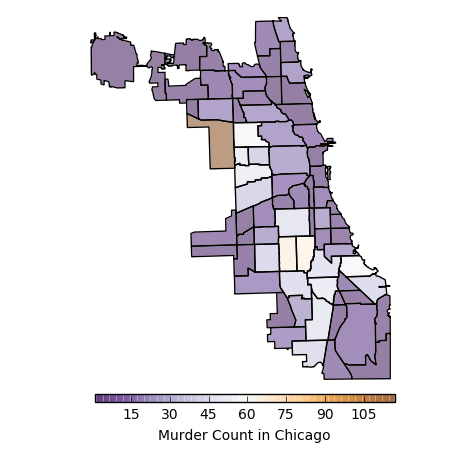

In [61]:
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize

ft, col, alpha = "Murder Count", "PuOr_r", 0.5
albers = merged.to_crs(epsg=3528) # EPSG Illinois East

# could change the limits here
norm = Normalize(vmin = albers[ft].min(), vmax = albers[ft].max()) 

cmap = plt.cm.ScalarMappable(norm=norm, cmap = col)

ax = albers.plot(color = "white", edgecolor = "white", figsize = (5, 5))
for xi, row in albers.iterrows():
    albers[albers.index == xi].plot(ax = ax, alpha = alpha, facecolor = cmap.to_rgba(row[ft]))

ax.set_axis_off()

fig = ax.get_figure()
cax = fig.add_axes([0.22, 0.13, 0.60, 0.015])
sm = plt.cm.ScalarMappable(cmap = col, norm=norm)
sm._A = [] # gross
fig.colorbar(sm, cax = cax, alpha = alpha, label = "Murder Count in Chicago", orientation='horizontal')
fig.savefig('choropleth.pdf', dpi=300, transparent=True, bbox_inches = "tight", pad_inches=0.2)
# plt.close(fig)

This is actually a pretty powerful way of doing it (it was in advanced, as well), but it has a number of drawbacks.  Namely, it will get confused if any of the bins are not populated, and it will put the lend in a wacky order by default (alphabetize -- hence the leading zeroes).

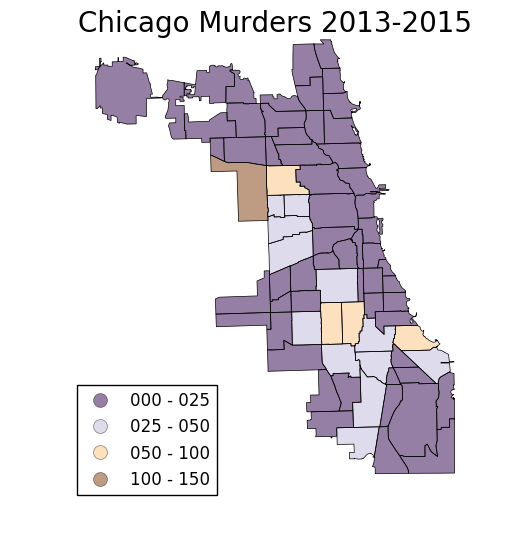

In [62]:
import pysal as ps

ft, bins = "Murder Count", 10

q = ps.Quantiles(merged[ft], k = bins)

my_bins = [0, 25, 50, 100, 150]
ud = ps.User_Defined(merged[ft], my_bins)

labels = ["{:03d} - {:03d}".format(ud.bins[i], ud.bins[i+1]) for i in range(len(ud.bins)-1)]

merged["udyb"] = ud.yb
merged["bins"] = pd.Series(merged["udyb"], dtype="category")
merged["bins"].cat.rename_categories(labels, inplace = True)

ax = merged.to_crs(epsg=3528).plot(column = "bins", categorical = True, figsize = (7, 6), 
                                   linewidth = 0.5, cmap = "PuOr_r", legend = True)

ax.set_title("Chicago Murders 2013-2015", fontsize = 20)
ax.set_axis_off()

In [63]:
import folium

m = folium.Map([41.7851555, -87.5940494865461], 
               tiles='cartodbpositron', 
               zoom_start=10, max_zoom = 18, min_zoom=10)

ft = "Murder Count"
cmap = folium.colormap.linear.PuOr.scale(-20, 140)

folium.GeoJson(merged,
               style_function=lambda feature: {
                'fillColor': cmap(feature['properties'][ft]),
                'fillOpacity' : 0.6,
                'weight' : 2, 'color' : 'black'
               }).add_to(m)

cmap.caption = ft
cmap.add_to(m)

m.save("murder_count.html")
m